In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
import numpy as np
import cv2
import json
import carla
from dgp.contribs.carla.carladgpagent import  get_initial_static_boxes, CarlaDGPAgent
from dgp.contribs.carla.carlatodgp import DGPSceneConstructor
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Get the traffic generation script from here
#!wget https://raw.githubusercontent.com/carla-simulator/carla/master/PythonAPI/examples/generate_traffic.py

In [3]:
client = carla.Client('localhost', 2000)
client.set_timeout(20.0)

In [4]:
print(client.get_server_version())
print(client.get_client_version())
print(client.get_available_maps())

a1b37f7f
0.9.13
['/Game/Carla/Maps/Town02', '/Game/Carla/Maps/Town10HD_Opt', '/Game/Carla/Maps/Town04', '/Game/Carla/Maps/Town01', '/Game/Carla/Maps/Town03', '/Game/Carla/Maps/Town03_Opt', '/Game/Carla/Maps/Town05', '/Game/Carla/Maps/Town10HD', '/Game/Carla/Maps/Town04_Opt', '/Game/Carla/Maps/Town02_Opt', '/Game/Carla/Maps/Town05_Opt', '/Game/Carla/Maps/Town01_Opt', '/Game/Carla/Maps/Town07_Opt', '/Game/Carla/Maps/Town06', '/Game/Carla/Maps/Town06_Opt', '/Game/Carla/Maps/Town07', '/Game/Carla/Maps/Town11/Town11']


In [5]:
world = client.reload_world()
world = client.get_world()

client.load_world("Town10HD")

traffic_manager = client.get_trafficmanager(8000)
traffic_manager.set_synchronous_mode(True)

settings = world.get_settings()
settings.fixed_delta_seconds = .1
settings.synchronous_mode = True
settings.substepping = True
settings.max_substep_delta_time = 0.01
settings.max_substeps = 10

world.apply_settings(settings)

client.reload_world(False)

static_boxes = get_initial_static_boxes(world)

weather = world.get_weather()
world.set_weather(weather.ClearSunset)

world.tick()

2

In [6]:
# create an agent

with open('../configs/car-dev.json', 'rb') as f:
    car_spec = json.loads(f.read())

transform = np.random.choice(world.get_map().get_spawn_points())

vehicle = CarlaDGPAgent(world, car_spec['model'], None, transform,
                       car_spec['datums'], static_boxes = static_boxes)
world.tick()
vehicle.ego.set_autopilot(True)
world.tick()

4

In [7]:
# At this point we should generate some traffic. Run generate_traffic.py in asynchronous mode

In [8]:
# Let all the actors wake up a bit
for i in range(10):
    world.tick()

In [9]:
# some helpful drawing utils

def dton(depth) -> np.ndarray:
    """Depth to image. Converts depth map to inverse depth image uint8 for drawing/display"""
    cmap = get_cmap('plasma')
    mask = depth <= 0
    depth[mask] = np.inf
    depth = 1 / (depth + 1e-5)
    depth = depth / np.percentile(depth, 95)
    x = 255 * cmap(depth)[:, :, :3]
    x = x.astype(np.uint8)
    x[mask] = 0
    return x

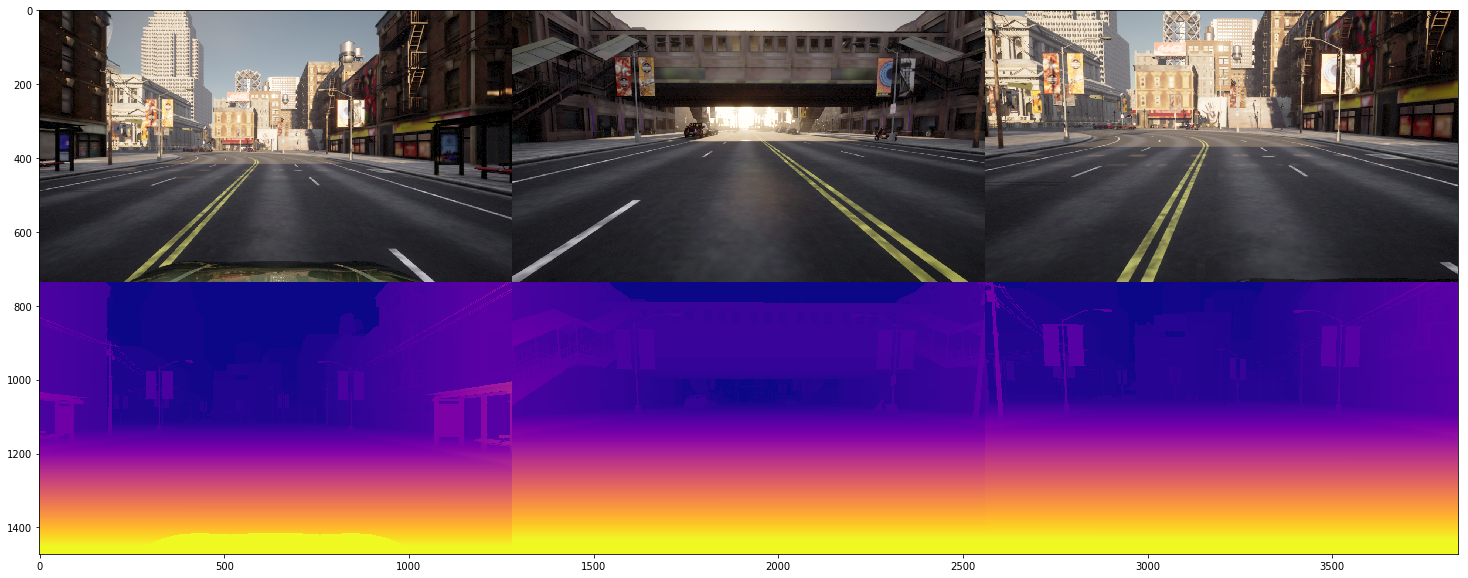

In [10]:
frame = world.tick(30) # << if on a remote host and/or with a slow simulator, allow a large timeout
sample = vehicle.get_sample(frame)

left, center, right = np.array(sample[1]['rgb']), np.array(sample[0]['rgb']), np.array(sample[2]['rgb'])

x = np.hstack( [ left,center, right])#, cv2.cvtColor(disp, cv2.COLOR_GRAY2BGR)])
dims = [
            dton(sample[i]['depth'].depth) for i in [1,0,2]
        ]

y = np.hstack(dims)
z = np.vstack([x,y])
plt.figure(figsize=(30,10))
plt.imshow(z)

In [11]:
# Save some scenes
for idx in range(1):
    scene_writer = DGPSceneConstructor('carla'+ str(idx))

    #warm up
    #for i in range(30):
    frame = world.tick(30)
    sample = vehicle.get_sample(frame)

    for i in tqdm(range(20)): # short 20 frame scene for example
        frame =world.tick(20.0)
        sample = vehicle.get_sample(frame)
        if sample is not None:
            scene_writer.create_new_sample()
            lidar_datum_idx = [idx for idx,datum in enumerate(sample) if datum['datum_name'] =='lidar'][0]
            lidar_datum = sample[lidar_datum_idx]

            scene_writer.add_point_cloud_datum(sample[-1])
            scene_writer.save_ontology(vehicle.ontology_table['bounding_box_3d'], 'bounding_box_3d')
            scene_writer.save_ontology(vehicle.ontology_table['semantic_segmentation_2d'], 'semantic_segmentation_2d')

            for i in range(len(sample)):
                if i == lidar_datum_idx:
                    continue
                scene_writer.add_camera_datum(sample[i])
        else:
            print('skipping bad sample')

    scene_writer.dump_scene()
    print('done')

  0%|          | 0/20 [00:00<?, ?it/s]

saved ontology 1 1eda2bcf7cca89eb734bff70dadd0fd04877d83b carla0/ontology
saved ontology 2 219a97aac6f8e0870c6e48f0a4a574ce2d7e928a carla0/ontology


100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

--------------------------------------------------------------------------------
From `DGPSceneConstructor.dump_scene`:
Datum name "lidar" has 20 datums
Datum name "camera_back" has 20 datums
Datum name "camera_front" has 20 datums
Datum name "camera_front_L" has 20 datums
Datum name "camera_front_R" has 20 datums
Datum name "camera_left" has 20 datums
Datum name "camera_left_wide" has 20 datums
Datum name "camera_right" has 20 datums
Datum name "drone" has 20 datums
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
done
